In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import time
from datetime import datetime
pio.renderers.default='notebook'


plt.rcParams.update({'font.size': 18})
%config InlineBackend.figure_format = 'retina'

In [2]:
def mean(x, period):
    return np.array([x[i * period : (i+1) * period].sum() / len(x[i * period : (i+1) * period])
                     for i in range(int(x.shape[0] / period))]) 

In [3]:
df = pd.read_csv('data/from_rtds.csv')
df = df[:200_000]
df.datetime = pd.to_datetime(df.datetime)

core_log = df.soc_core.values / 100


Ёмкость опорно-балансирующей батареи $33kWh $

Ёмкость батареи гибкости $100kWh$, ресурс $3000$ циклов, стоимость $1000\$ / kWh$

Средняя мощность ветрогенерации $22kW$

Мощность нагрузки $70kW$

Резервируемая мощность $30kW$

Text(0, 0.5, 'SoE, %')

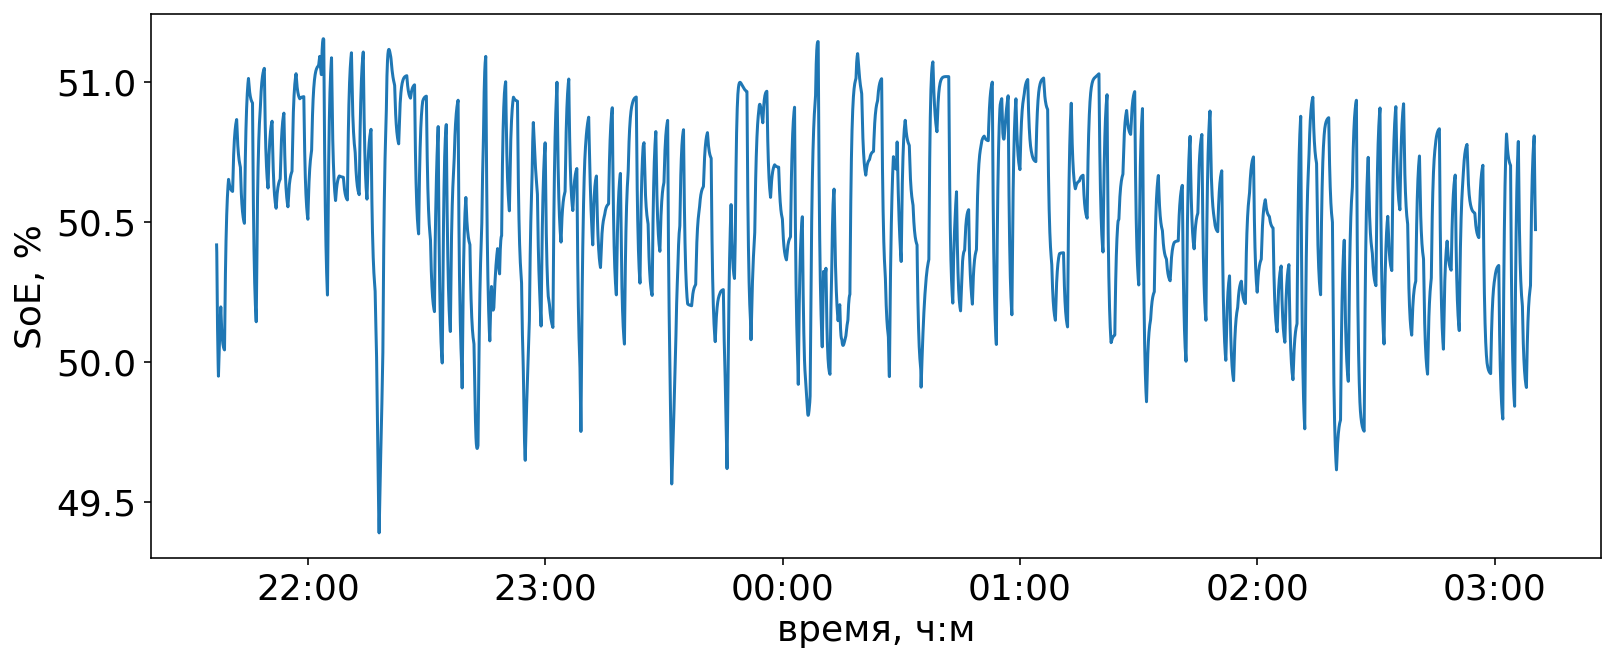

In [4]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(13,5))
plt.plot(df.datetime, core_log*100)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))
plt.xlabel('время, ч:м')
plt.ylabel('SoE, %')

In [5]:
def count_cycles(socs, depth, verbose=False):
    low, hi = 0, 0
    cycles = 0    
    
#     socs = remove_horizontals(socs)
    for i in range(1, len(socs)-1):
        s, p, n = socs[i], socs[i-1], socs[i+1]
        
        if s > p and s > n or s < p and s < n:
        
            if low > hi and socs[hi] - socs[low] > depth and s - socs[low] > depth:
                if verbose:  print('d-c', hi, low, i)
                cycles += 1
                low, hi = i, i
            elif low < hi and socs[hi] - socs[low] > depth and socs[hi] - s > depth:
                if verbose: print('c-d',low, hi, i)
                cycles += 1
                low, hi = i, i
            else:
                if s < socs[low]: low = i
                if s > socs[hi]: hi = i
                
    return cycles

In [6]:
from math import inf
from heapq import *

def remove_horizontals(x):
    x = list(x)
    n = len(x)
    i, k = 1, 1
    while i < n: 
        if x[i] != x[i-1]:
            x[k] = x[i]
            k += 1
        i += 1
    n = k
    return np.array(x[:n])

def find_cycles(socs):
    def collapse_last(maxs, mins, socs):
#         print(mins, maxs)
        mx = maxs.pop()
        mn = mins.pop()
        return socs[mx] - socs[mn]

    cycles = []
    maxs, mins = [], []
            
    socs = remove_horizontals(socs)
    print (socs.shape)
    for i in range(1, len(socs)-1):
        s, p, n = socs[i], socs[i-1], socs[i+1]
        if s > p and s > n:
#             print(i, s, p, n)
            while maxs and s >= socs[maxs[-1]]: 
#                 print(f'{i}, collapse max', end=' ')
                cycles.append(collapse_last(maxs, mins, socs))
            maxs.append(i)
        elif s < p and s < n:
            while mins and s <= socs[mins[-1]]:
#                 print(f'{i}, collapse min', end=' ')
                cycles.append(collapse_last(maxs, mins, socs))
            mins.append(i)
    print(len(maxs), len(mins))
    while mins and maxs:
         cycles.append(collapse_last(maxs, mins, socs))
    return np.array(cycles)

In [7]:
%%time
cycles = find_cycles(core_log)

(199231,)
5 5
CPU times: user 152 ms, sys: 5.98 ms, total: 158 ms
Wall time: 157 ms


## Функция плотности распределения циклов

Здесь должна быть постановка задачи, обоснование корректности постановки и описание алгоритма

Text(0, 0.5, 'Количество циклов')

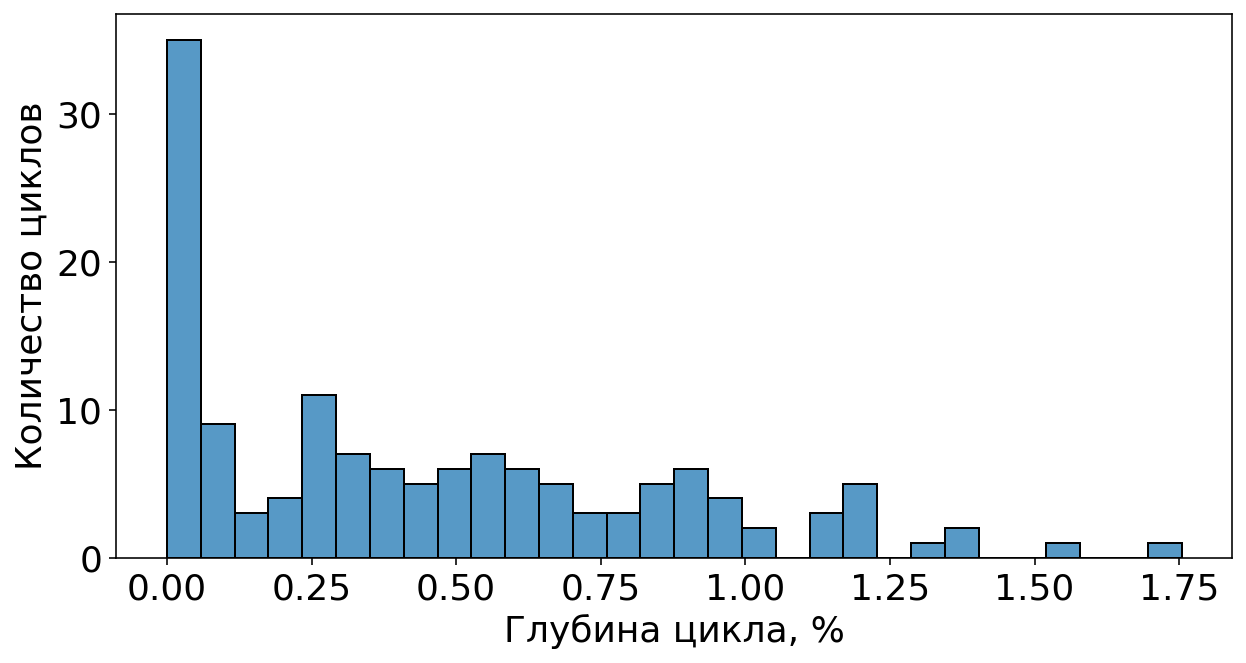

In [8]:
plt.figure(figsize=(10,5))
sns.histplot(cycles*100, bins=30)
plt.xlabel('Глубина цикла, %')
plt.ylabel('Количество циклов')

In [9]:
np.histogram(cycles[::-1])

(array([47, 22, 17, 18, 11, 12,  8,  3,  1,  1]),
 array([3.80999999e-08, 1.75417705e-03, 3.50831600e-03, 5.26245495e-03,
        7.01659390e-03, 8.77073285e-03, 1.05248718e-02, 1.22790108e-02,
        1.40331497e-02, 1.57872887e-02, 1.75414276e-02]))

### Методика подсчёта циклов 
Циклом глубины $d$ считаем участок кривой SoC такой, что для некоторых принадлежащих ему трёх моментов времени $t_1 < t_2 < t_3$ выполнено 
$$(SoC(t_2) - SoC(t_1) > d \wedge SoC(t_2) - SoC(t_3) > d) \vee (SoC(t_1) - SoC(t_2) > d \wedge SoC(t_3) - SoC(t_2) > d) $$

Количество циклов определеяется путём обхода кривой SoC слева направо и последовательным выделением наименьших циклов

In [10]:
%%time
depths = np.linspace(0, 0.02, 20) 
core_cycles, battery_cycles=[],[]
socs = remove_horizontals(core_log)
for d in depths:
    core_cycles.append(count_cycles(socs, d))
#     battery_cycles.append(count_cycles(battery_log, d))

CPU times: user 1.94 s, sys: 3.19 ms, total: 1.95 s
Wall time: 1.95 s


In [11]:
depths, core_cycles 

(array([0.        , 0.00105263, 0.00210526, 0.00315789, 0.00421053,
        0.00526316, 0.00631579, 0.00736842, 0.00842105, 0.00947368,
        0.01052632, 0.01157895, 0.01263158, 0.01368421, 0.01473684,
        0.01578947, 0.01684211, 0.01789474, 0.01894737, 0.02      ]),
 [140, 99, 91, 81, 68, 55, 45, 35, 31, 17, 13, 12, 6, 3, 2, 1, 1, 0, 0, 0])

Text(0, 0.5, 'Количество циклов \nбольшей глубины')

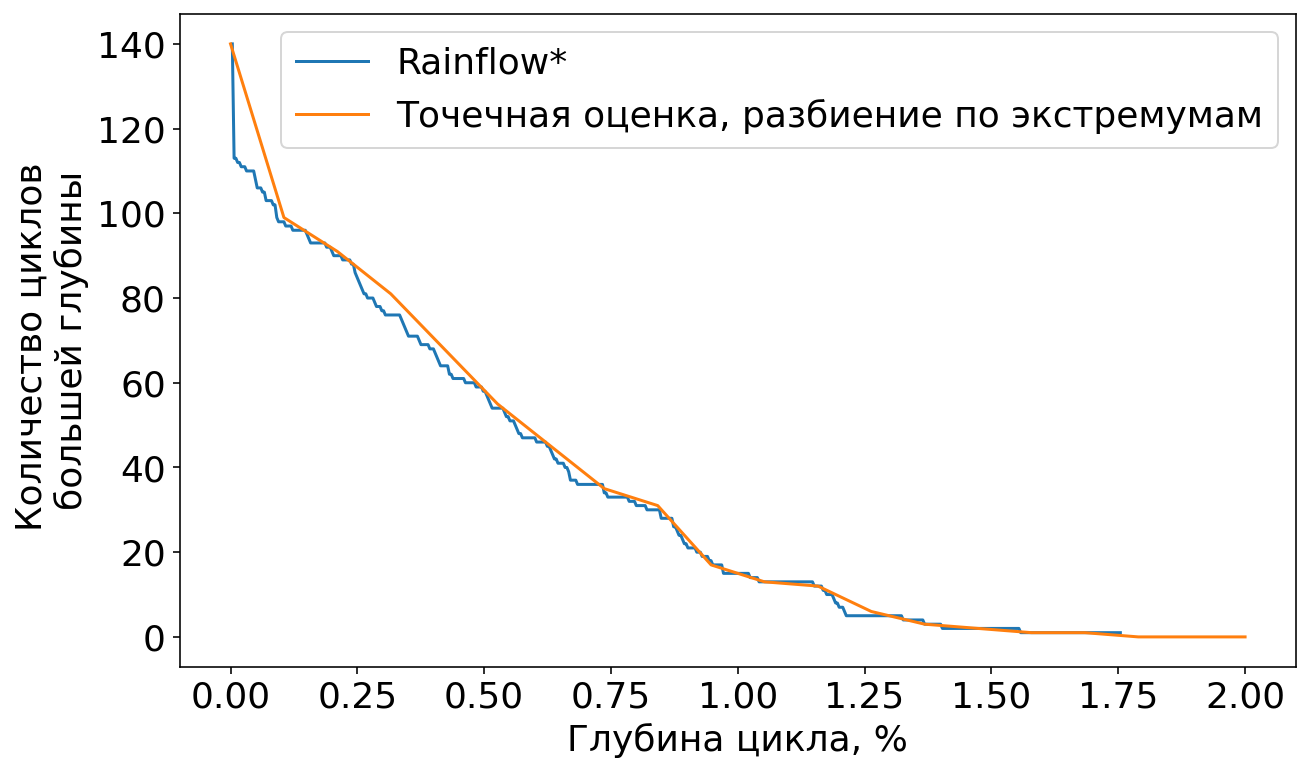

In [12]:
plt.figure(figsize=(10,6))
h = np.histogram(cycles[::-1], bins=500)
plt.plot(h[1][1:]*100, np.cumsum(h[0][::-1])[::-1], label='Rainflow*')
plt.plot(depths*100, core_cycles, label='Точечная оценка, разбиение по экстремумам')
plt.legend()
plt.xlabel('Глубина цикла, %')
plt.ylabel('''Количество циклов 
большей глубины''')

In [13]:
len(cycles), core_cycles

(140,
 [140, 99, 91, 81, 68, 55, 45, 35, 31, 17, 13, 12, 6, 3, 2, 1, 1, 0, 0, 0])

In [14]:
num = 0
socs = remove_horizontals(core_log)
# socs = core_log
for i in range(1, len(socs)-1):
    s, p, n = socs[i], socs[i-1], socs[i+1]
    if s > p and s > n or s < p and s < n:
        num += 1
print(num)

280
